In [1]:
"""
Re‑creates your current world + camera demo and opens a matplotlib window.
Run:  python -m examples.demo_world
"""
import numpy as np
from nerflab import (
    Intrinsics, Camera, Box, Sphere, World,
    stratified_samples_batch, plot_world, CFG, pose_H, make_pose_cases
)


In [2]:
# build preset dictionary
cases = make_pose_cases(axis_dist=3)

# pick a view (e.g., diagonal)
H_wc = pose_H(cases["+Z"])  
# H_wc = np.eye(4)
print(H_wc)

[[ 1.  0. -0.  0.]
 [-0.  1. -0.  0.]
 [ 0.  0.  1.  3.]
 [ 0.  0.  0.  1.]]


In [3]:
# --- camera ------------------------------------------------------------------
# H_wc = np.eye(4, dtype=np.float32)        # simple origin‑facing camera
intr  = Intrinsics(**CFG.intrinsics.__dict__)
cam   = Camera(intr, H_wc,
               t_bounds=(CFG.rays.t_near, CFG.rays.t_far))

# --- sample rays -------------------------------------------------------------
O_w, D_w = cam.get_rays(frame="world")
t, delta, pts = stratified_samples_batch(
    O_w, D_w, CFG.rays.t_near, CFG.rays.t_far,
    N=CFG.rays.N, deterministic=CFG.rays.deterministic
)
print("points shape:", pts.shape)


points shape: (307200, 20, 3)


density at (0,2,1): 0.0


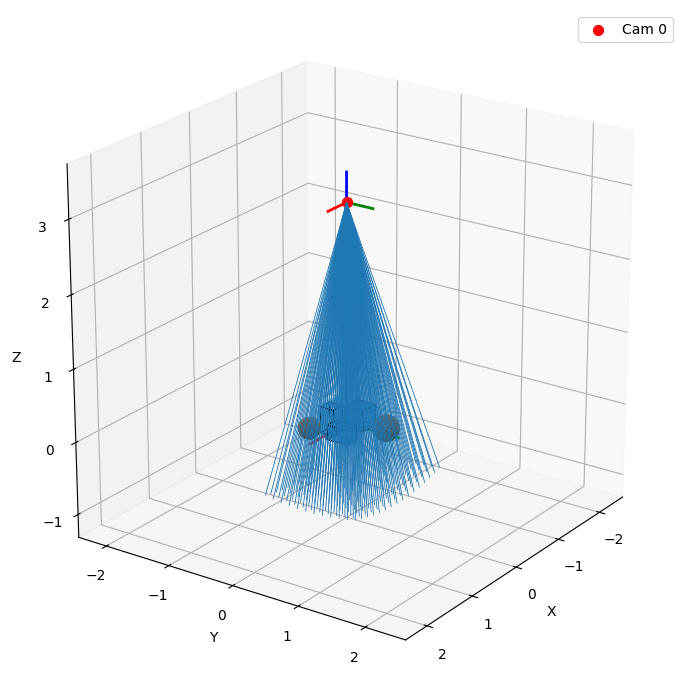

In [4]:
# --- build world -------------------------------------------------------------
# ------------------------------------------------------------
# Scaled‑down world  (factor = 0.20)
# ------------------------------------------------------------
world = World()

# Boxes
world.add_shape(Box(center=(-0.30,  0.00, 0.0), size=(0.28, 0.28, 0.28)))
world.add_shape(Box(center=( 0.28,  0.12, 0.0), size=(0.20, 0.32, 0.20)))
world.add_shape(Box(center=( 0.00, -0.24, 0.0), size=(0.20, 0.20, 0.36)))

# Spheres
world.add_shape(Sphere(center=(-0.16,  0.50, 0.0), radius=0.17))
world.add_shape(Sphere(center=( 0.40, -0.30, 0.0), radius=0.14))

# Check the density of a point
x,y,z = (0,2,1)
print("density at (0,2,1):", world.density(x, y, z))

from nerflab.viz import viz_cfg
viz_cfg.figsize = (9, 7)
viz_cfg.default_alpha = 0.5
# --- visualise ---------------------------------------------------------------
plot_world(world, cameras=[cam], draw_rays=True, t_near=0.1, t_far = 4)

In [5]:
cam.print_info()

=== Camera ===
Res: 480 x 640
fx, fy: 1200.00, 1200.00
cx, cy: 320.00, 240.00
t_bounds: [10, 15]
H_wc:
 [[ 1.  0. -0.  0.]
 [-0.  1. -0.  0.]
 [ 0.  0.  1.  3.]
 [ 0.  0.  0.  1.]]


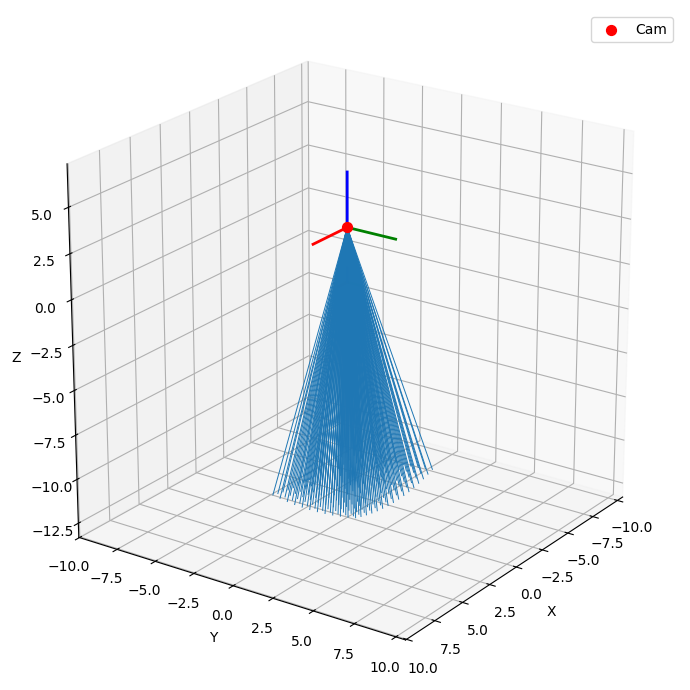

In [6]:
cam.plot_rays()